In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [13]:
def load_dataset(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    class_names = []

    # Traverse through TRAIN and TEST directories
    for split in ['TRAIN', 'TEST']:
        split_path = os.path.join(data_dir, split)
        if not os.path.isdir(split_path):
            print(f"Directory not found: {split_path}")
            continue
        for class_name in sorted(os.listdir(split_path)):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            if class_name not in class_names:
                class_names.append(class_name)
            class_idx = class_names.index(class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names


In [14]:
DATASET_DIR = "./DATASET"
IMG_SIZE = (128, 128)
images, labels, class_names = load_dataset(DATASET_DIR, IMG_SIZE)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)


In [15]:
# Debug Dataset Loading
print(f"Loaded {len(images)} images across {len(class_names)} classes.")
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No data was loaded. Please check the dataset directory structure and permissions.")

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Debug Split
print(f"Training data: {len(X_train)} samples")
print(f"Test data: {len(X_test)} samples")


Loaded 25077 images across 2 classes.
Training data: 20061 samples
Test data: 5016 samples


In [16]:
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
data_gen.fit(X_train)


In [20]:
# Step 4: Build the CNN Model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model((IMG_SIZE[0], IMG_SIZE[1], 3), len(class_names))


In [21]:
# Step 5: Train the Model
checkpoint_path = "best_model.keras" 
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 313s 494ms/step - accuracy: 0.7465 - loss: 1.7888 - val_accuracy: 0.7873 - val_loss: 0.5414
Epoch 2/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 302s 481ms/step - accuracy: 0.8091 - loss: 0.4662 - val_accuracy: 0.8497 - val_loss: 0.4084
Epoch 3/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 299s 476ms/step - accuracy: 0.8074 - loss: 0.4437 - val_accuracy: 0.7358 - val_loss: 0.5462
Epoch 4/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 295s 470ms/step - accuracy: 0.8181 - loss: 0.4243 - val_accuracy: 0.8355 - val_loss: 0.3844
Epoch 5/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 305s 486ms/step - accuracy: 0.8200 - loss: 0.4345 - val_accuracy: 0.8620 - val_loss: 0.3755


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8646 - loss: 0.3598
Test Loss: 0.3754701614379883, Test Accuracy: 0.8620414733886719
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step
              precision    recall  f1-score   support

           O       0.88      0.87      0.88      2794
           R       0.84      0.85      0.85      2222

    accuracy                           0.86      5016
   macro avg       0.86      0.86      0.86      5016
weighted avg       0.86      0.86      0.86      5016

Confusion Matrix:
[[2431  363]
 [ 329 1893]]


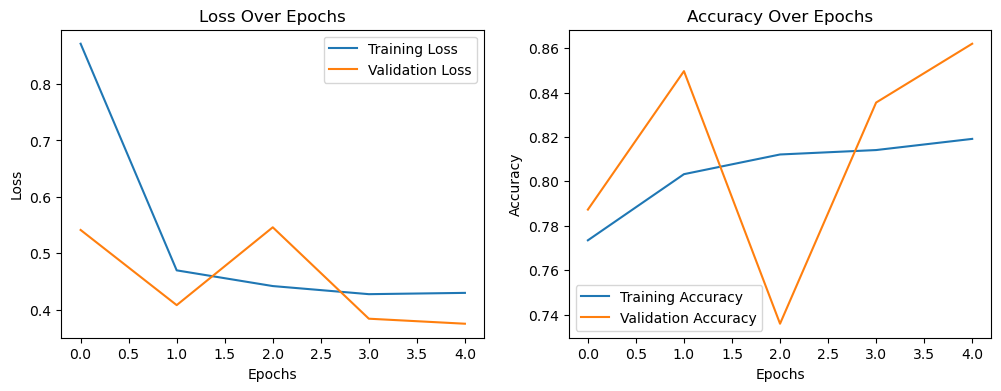

In [22]:
# Step 6: Evaluate the Model
model.load_weights(checkpoint_path)
eval_metrics = model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_metrics[0]}, Test Accuracy: {eval_metrics[1]}")

# Classification Report and Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)


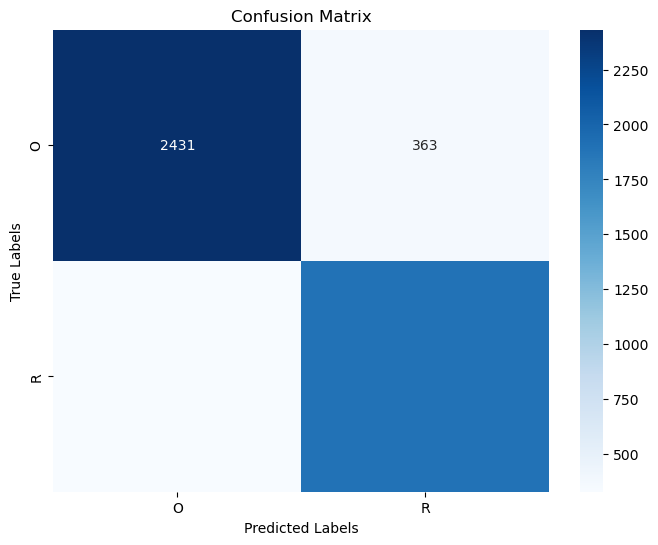

In [27]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

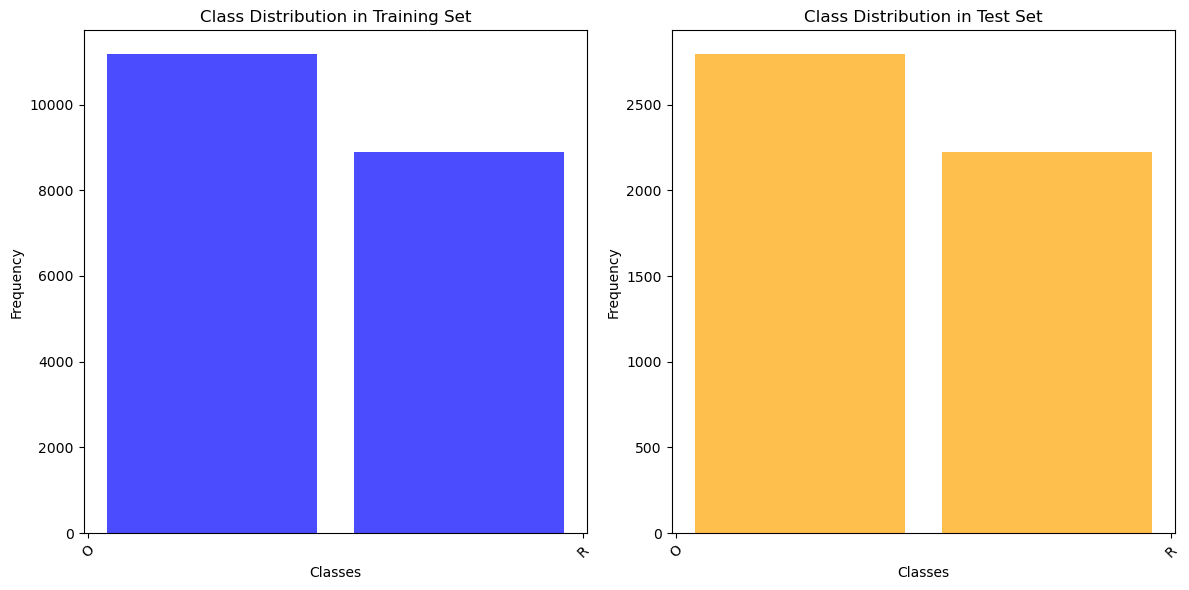

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=len(class_names), alpha=0.7, color='blue', rwidth=0.85)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=len(class_names), alpha=0.7, color='orange', rwidth=0.85)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title('Class Distribution in Test Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
# Step 7: Deployment Utility Functions
def predict_waste(image_path, model_path, class_names, img_size=(128, 128)):
    model = tf.keras.models.load_model(model_path)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return class_names[np.argmax(prediction)]


In [25]:
predicted_class = predict_waste("./DATASET/TRAIN/R/R_171.jpg", checkpoint_path, class_names)
print("Predicted Waste Type:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Predicted Waste Type: R
